# Matrix results analysis

In [1]:
import numpy as np
import pickle
import json
import os

import osmnx as ox

from tqdm import tqdm
import matplotlib.pyplot as plt

from data import get_data
from random_walks import get_end_nodes

In [2]:
with open("./places.json") as fin:
    places = json.load(fin)

## Compress edges

For every node, consider starting there as the starting point. We can travel to any of the neighbors with equal probability; take an average and add distance.

In [3]:
def save_average_time(slug, overwrite=False):
    """
    Take the data from solve_matrix.py and average
        results across nodes, not edges.
    """
    save_path = f"./output/avg_time/{slug}.pkl"
    if not overwrite and os.path.exists(save_path):
        print(f"  File {save_path} already exists. Skipping...")
        return

    with open(f"./output/matrix_method/{slug}.pkl", "rb") as fin:
        results = pickle.load(fin)
        
    E_time_edge, states = results["expected_time"], results["states"]
    state2idx = {state: idx for idx, state in enumerate(states)}

    G, adj, boba_gdf = get_data(slug)
    end_nodes = get_end_nodes(G, boba_gdf)

    nodes = sorted(adj.keys())
    # node2idx = {node: idx for idx, node in enumerate(nodes)}

    E_time = {}
    for params in tqdm(E_time_edge):
        E_time[params] = np.zeros(len(nodes))

        for i, node in enumerate(nodes):
            if node in end_nodes:
                continue

            tot = 0
            for edge in adj[node]:
                nbr, length, _, _ = edge
                if nbr in end_nodes:
                    tot += 0
                else:
                    tot += E_time_edge[params][state2idx[(nbr, node)]]
                tot += length
            
            E_time[params][i] = tot / len(adj[node])

    os.makedirs("./output/avg_time", exist_ok=True)
    with open(save_path, "wb") as fout:
        pickle.dump(E_time, fout)

In [4]:
for placename, coords, slug in places:
    print(f"Computing weights for {placename} (slug: {slug})")
    save_average_time(slug, overwrite=False)
    print()

Computing weights for Harvard (slug: harvard)
  File ./output/avg_time/harvard.pkl already exists. Skipping...

Computing weights for MIT (slug: mit)
  File ./output/avg_time/mit.pkl already exists. Skipping...

Computing weights for UW Seattle (slug: uw_seattle)
  File ./output/avg_time/uw_seattle.pkl already exists. Skipping...

Computing weights for University of Chicago (slug: uchicago)
  File ./output/avg_time/uchicago.pkl already exists. Skipping...

Computing weights for Dartmouth (slug: dartmouth)
  File ./output/avg_time/dartmouth.pkl already exists. Skipping...

Computing weights for Boston University (slug: boston_university)
  File ./output/avg_time/boston_university.pkl already exists. Skipping...

Computing weights for Princeton (slug: princeton)
  File ./output/avg_time/princeton.pkl already exists. Skipping...

Computing weights for Stanford (slug: stanford)
  File ./output/avg_time/stanford.pkl already exists. Skipping...

Computing weights for Yale (slug: yale)
  File

100%|██████████| 70/70 [00:01<00:00, 40.31it/s]



Computing weights for Carnegie Mellon (slug: carnegie_mellon)


100%|██████████| 70/70 [00:00<00:00, 150.37it/s]

## Sensitivity to parameters

### Raw random walk time for Harvard

In [3]:
slug = "boston_university"
placename = next(placename for placename, _, s in places if s == slug)

with open(f"./output/avg_time/{slug}.pkl", "rb") as fin:
    E_time = pickle.load(fin)

In [4]:
print(f"Available angles: {sorted(set([key[0] for key in E_time.keys()]))}")
print(f"Available favors: {sorted(set([key[1] for key in E_time.keys()]))}")

Available angles: [0.0, 30.0, 45.0, 60.0, 90.0, 120.0, 135.0]
Available favors: [0.0001, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0, 20.0, 100.0]


In [5]:
angles = [0, 30, 60, 90, 120]
favors = [1, 2, 3, 4, 5, 10]

results = np.zeros((len(angles), len(favors)))

In [6]:
for i, angle in enumerate(angles):
    for j, favor in enumerate(favors):
        results[i,j] = np.median(E_time[(angle, favor)])

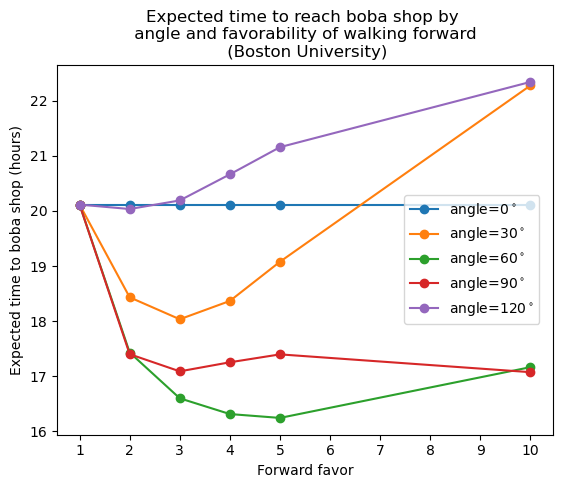

In [7]:
fig, ax = plt.subplots()

for angle in angles:
    plt.plot(favors, results[angles.index(angle)] / 60, "o-", label=fr"angle=${angle:.0f}^\circ$")

# ax.set_xscale("log")
# ax.set_yscale("log")
ax.ticklabel_format(style='plain')

plt.xticks(range(1, 11))
plt.xlabel("Forward favor")
plt.ylabel(f"Expected time to boba shop (hours)")
plt.title(f"Expected time to reach boba shop by \n angle and favorability of walking forward \n ({placename})");

# plt.legend(loc="lower right");
plt.legend(loc=(0.7, 0.3));

### "Inefficiency" for Harvard

Compute (expected random walk time) / (shortest time)

In [10]:
slug = "harvard"

In [11]:
G, adj, boba_gdf = get_data(slug)
print(f"Graph has {len(G.nodes()):,} nodes and {len(G.edges()):,} edges.")
nodes = sorted(adj.keys())

Graph has 27,191 nodes and 77,299 edges.


In [12]:
end_nodes = get_end_nodes(G, boba_gdf)
print(f"{len(end_nodes)} end nodes")

259 end nodes


In [13]:
angle, favor = 60, 5
with open(f"./output/avg_time/{slug}.pkl", "rb") as fin:
    E_time = pickle.load(fin)[(angle, favor)]

with open(f"./data/shortest_paths/{slug}.pkl", "rb") as fin:
    shortest_paths = pickle.load(fin)

shortest_paths = np.array([shortest_paths[node] for node in nodes])

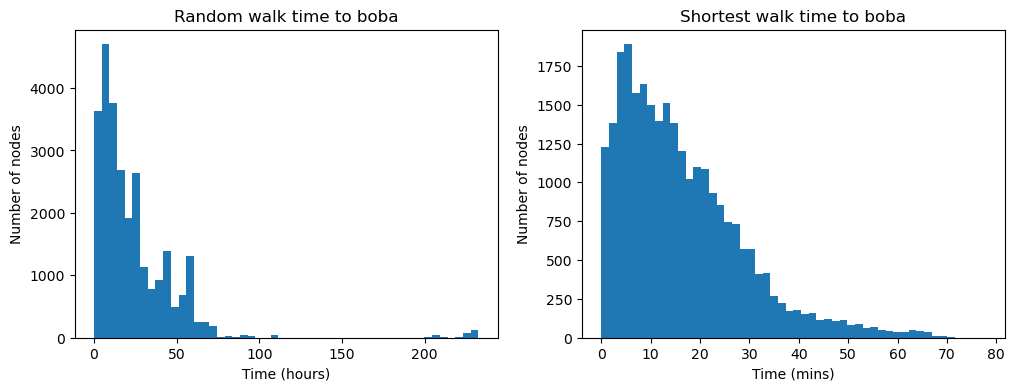

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

plt.axes(axs[0])
plt.xlabel("Time (hours)")
plt.ylabel("Number of nodes")
plt.title("Random walk time to boba")
plt.hist(E_time / 60, bins=50);

plt.axes(axs[1])
plt.xlabel("Time (mins)")
plt.ylabel("Number of nodes")
plt.title("Shortest walk time to boba")
plt.hist(shortest_paths, bins=50);

In [15]:
# Inefficiencies
ineffs = np.divide(E_time, shortest_paths, out=np.zeros_like(E_time), where=(shortest_paths != 0))

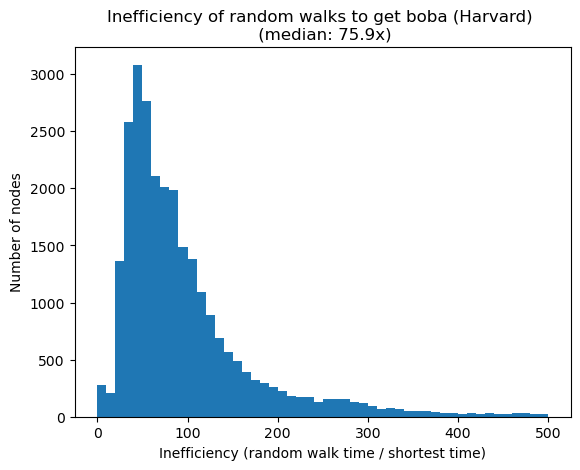

In [16]:
plt.xlabel("Inefficiency (random walk time / shortest time)")
plt.ylabel("Number of nodes")
plt.title(f"Inefficiency of random walks to get boba (Harvard) \n (median: {np.median(ineffs):.1f}x)")
plt.hist(ineffs[ineffs < 500], bins=50);

### Inefficiency analysis across all places

In [17]:
placenames = {slug: placename for placename, _, slug in places}

In [18]:
places

[['Harvard', [42.374194, -71.116608], 'harvard'],
 ['MIT', [42.37428, -71.11659], 'mit'],
 ['UW Seattle', [47.65728, -122.30724], 'uw_seattle'],
 ['University of Chicago', [41.7886, -87.59871], 'uchicago'],
 ['Dartmouth', [43.70444, -72.28869], 'dartmouth'],
 ['Boston University', [42.35049, -71.10539], 'boston_university'],
 ['Princeton', [40.34309, -74.65507], 'princeton'],
 ['Stanford', [37.42766, -122.17006], 'stanford'],
 ['Yale', [41.31632, -72.92234], 'yale'],
 ['Johns Hopkins', [39.3299, -76.62051], 'johns_hopkins'],
 ['University of Pennsylvania', [39.95221, -75.19321], 'upenn'],
 ['UCLA', [34.06991, -118.4438], 'ucla'],
 ['National Taiwan University',
  [25.01734, 121.53975],
  'national_taiwan_university'],
 ['Georgia Tech', [33.77561, -84.39628], 'georgia_tech'],
 ['Carnegie Mellon', [40.4432, -79.94284], 'carnegie_mellon']]

In [20]:
ineffs = {}

for i, place in enumerate(places):
    placename, coords, slug = place
    print(f"[{i:>2}/{len(places)}] Calculating inefficiency for {placename}...")

    G, adj, boba_gdf = get_data(slug)
    end_nodes = get_end_nodes(G, boba_gdf)
    nodes = sorted(adj.keys())

    angle, favor = 60, 5
    with open(f"./output/avg_time/{slug}.pkl", "rb") as fin:
        E_time = pickle.load(fin)[(angle, favor)]
    with open(f"./data/shortest_paths/{slug}.pkl", "rb") as fin:
        shortest_paths = pickle.load(fin)
    shortest_paths = np.array([shortest_paths[node] for node in nodes])

    # Inefficiencies
    ineffs[slug] = np.divide(E_time, shortest_paths, out=np.zeros_like(E_time), where=(shortest_paths != 0))

[ 0/15] Calculating inefficiency for Harvard...
[ 1/15] Calculating inefficiency for MIT...
[ 2/15] Calculating inefficiency for UW Seattle...
[ 3/15] Calculating inefficiency for University of Chicago...
[ 4/15] Calculating inefficiency for Dartmouth...
[ 5/15] Calculating inefficiency for Boston University...
[ 6/15] Calculating inefficiency for Princeton...
[ 7/15] Calculating inefficiency for Stanford...
[ 8/15] Calculating inefficiency for Yale...
[ 9/15] Calculating inefficiency for Johns Hopkins...
[10/15] Calculating inefficiency for University of Pennsylvania...
[11/15] Calculating inefficiency for UCLA...
[12/15] Calculating inefficiency for National Taiwan University...
[13/15] Calculating inefficiency for Georgia Tech...
[14/15] Calculating inefficiency for Carnegie Mellon...


In [21]:
all_ineffs = np.concatenate(list(ineffs.values()))

with open(f"./output/all_ineffs.pkl", "wb") as fout:
    pickle.dump(all_ineffs, fout)

### Analyze inefficiencies

In [13]:
with open(f"./output/all_ineffs.pkl", "rb") as fin:
    all_ineffs = pickle.load(fin)

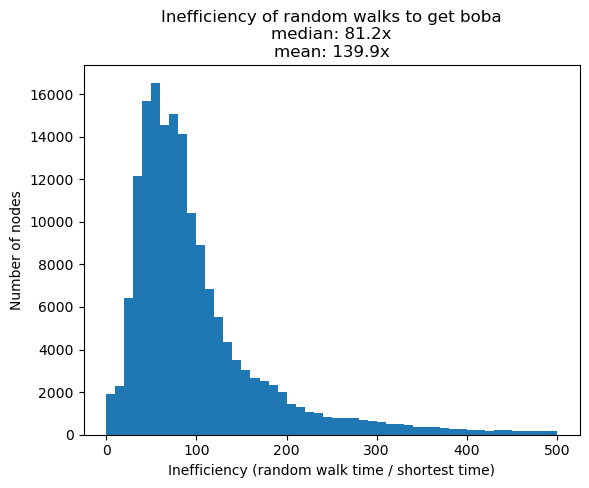

In [16]:
plt.xlabel("Inefficiency (random walk time / shortest time)")
plt.ylabel("Number of nodes")
plt.title(f"Inefficiency of random walks to get boba\nmedian: {np.median(all_ineffs):.1f}x\nmean: {np.mean(all_ineffs):.1f}x")
plt.hist(all_ineffs[all_ineffs < 500], bins=50);

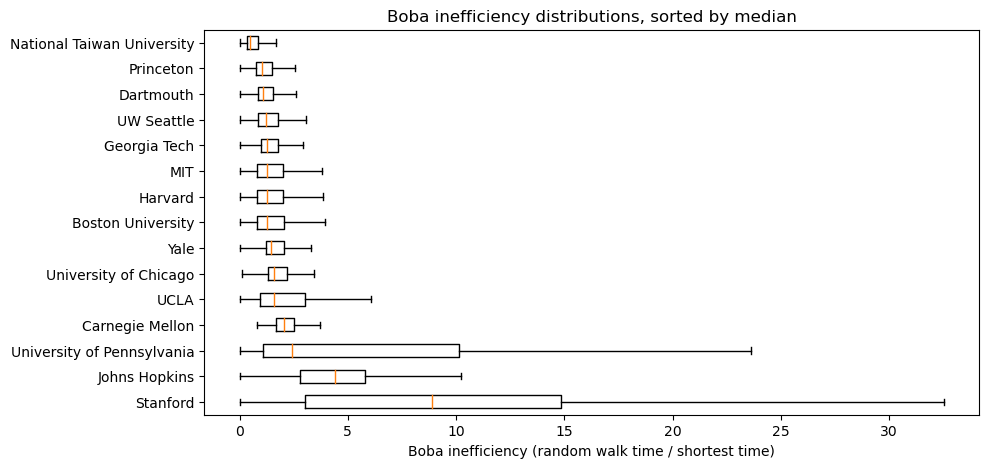

In [23]:
slugs = sorted(ineffs.keys(), key=lambda slug: -np.median(ineffs[slug]))
values = [ineffs[slug] / 60 for slug in slugs]

fig, ax = plt.subplots(figsize=(10, 5))
plt.xlabel("Boba inefficiency (random walk time / shortest time)")
plt.title("Boba inefficiency distributions, sorted by median")
plt.boxplot(values, labels=[placenames[slug] for slug in slugs], vert=False, showfliers=False);

## Where to go for college?

### Part 1

For each place, calculate random vs ideal time to boba

In [8]:
ideal_times_dict = {}
random_times_dict = {}

for placename, _, slug in tqdm(places):
    with open(f"./output/avg_time/{slug}.pkl", "rb") as fin:
        random_times_dict[slug] = np.mean(pickle.load(fin)[(60, 5)])
    with open(f"./data/shortest_paths/{slug}.pkl", "rb") as fin:
        ideal_times_dict[slug] = np.mean(list(pickle.load(fin).values()))

100%|██████████| 15/15 [00:00<00:00, 27.25it/s]


In [9]:
slug2placename = {slug: placename for placename, _, slug in places}
ideal_slugs = sorted(list(ideal_times_dict.keys()), key=lambda slug: -ideal_times_dict[slug])
random_slugs = sorted(list(ideal_times_dict.keys()), key=lambda slug: -random_times_dict[slug])

ideal_times = [ideal_times_dict[slug] for slug in ideal_slugs]
random_times = [random_times_dict[slug] / 60 for slug in random_slugs]

ideal_labels = [slug2placename[slug] for slug in ideal_slugs]
random_labels = [slug2placename[slug] for slug in random_slugs]

(0.0, 360.0)

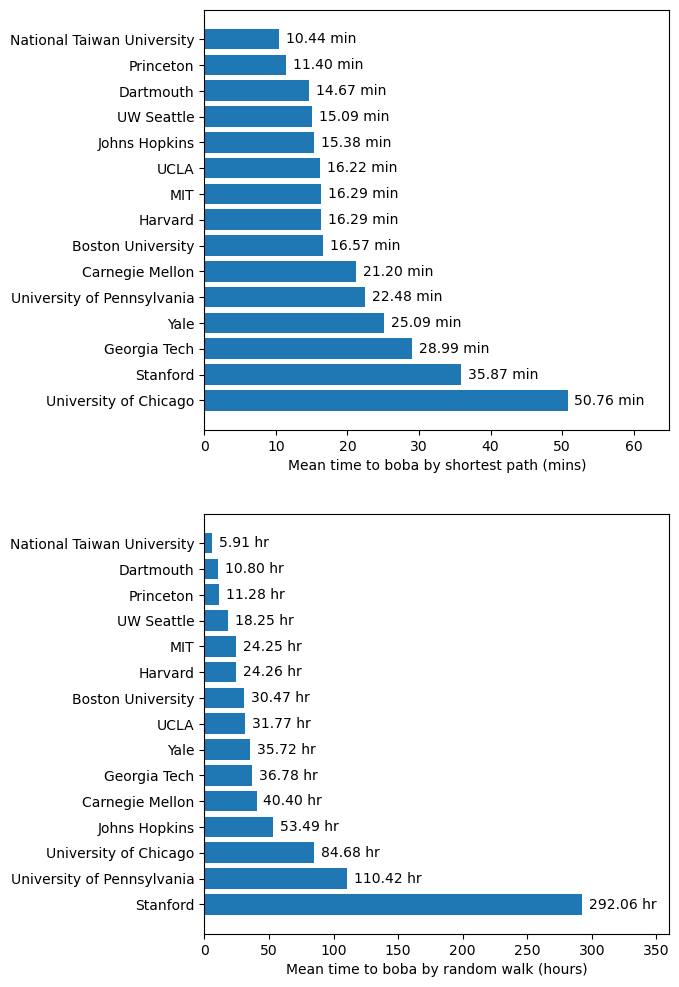

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(6, 12))

bar0 = axs[0].barh(
    np.arange(len(ideal_times)),
    width=ideal_times,
    height=0.8,
    tick_label=ideal_labels,
    align="center"
)
axs[0].set_xlabel("Mean time to boba by shortest path (mins)")
axs[0].bar_label(bar0, padding=5, fmt="%.2f min")
axs[0].set_xlim([0, 65])  # adjust xlim to fit labels

bar1 = axs[1].barh(
    np.arange(len(random_times)),
    width=random_times,
    height=0.8,
    tick_label=random_labels,
    align="center"
)
axs[1].set_xlabel("Mean time to boba by random walk (hours)")
axs[1].bar_label(bar1, padding=5, fmt="%.2f hr")
axs[1].set_xlim([0, 360])  # adjust xlim to fit labels

### Part 2

See if number of nodes is a confounding factor.

In [121]:
print(f"Fetching all data...")
data = {slug: get_data(slug) for _, _, slug in tqdm(places)}

Fetching all data...


100%|██████████| 15/15 [00:15<00:00,  1.06s/it]


### Check any correlation bewteen no. nodes and no. edges

Spoiler: yes, there is a correlation.

In [129]:
slugs = [place[2] for place in places]

Text(0, 0.5, 'Number of edges in network')

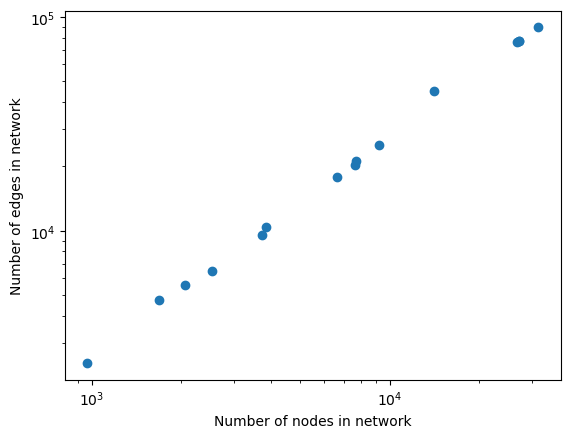

In [133]:
nodes_vs_edges = np.array([(len(data[slug][0].nodes()), len(data[slug][0].edges())) for slug in slugs])
plt.scatter(*nodes_vs_edges.T)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of nodes in network")
plt.ylabel("Number of edges in network");

### Correlation bewteen network size and boba time

In [149]:
from scipy.stats import linregress

In [170]:
def scatter_with_trendline(x, y, label):
    x, y = np.array(x), np.array(y)
    plt.scatter(x, y)   
    slope, intercept, r_value, _, _ = linregress(x, y)
    x2 = np.linspace(min(x), max(x), 100)
    plt.plot(x2, slope*x2 + intercept, label=f"{label} (R^2={r_value**2:.3f})")

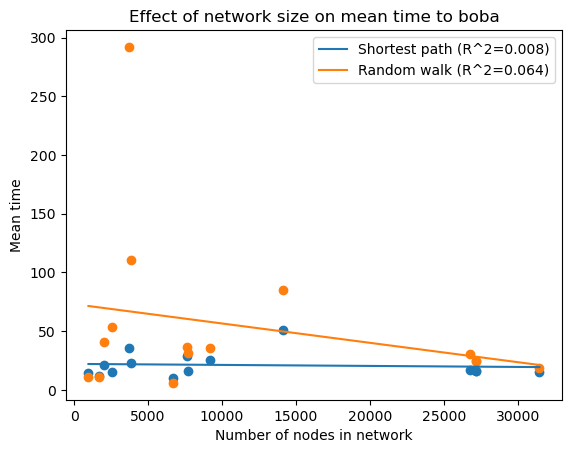

In [172]:
scatter_with_trendline([len(data[slug][0].nodes()) for slug in ideal_slugs], ideal_times, label="Shortest path")
scatter_with_trendline([len(data[slug][0].nodes()) for slug in random_slugs], random_times, label="Random walk")

plt.xlabel("Number of nodes in network")
plt.ylabel("Mean time")
plt.title("Effect of network size on mean time to boba")

""" plt.xscale("log")
plt.yscale("log") """

plt.legend()

### Check for correlation bewteen boba density and mean time to boba

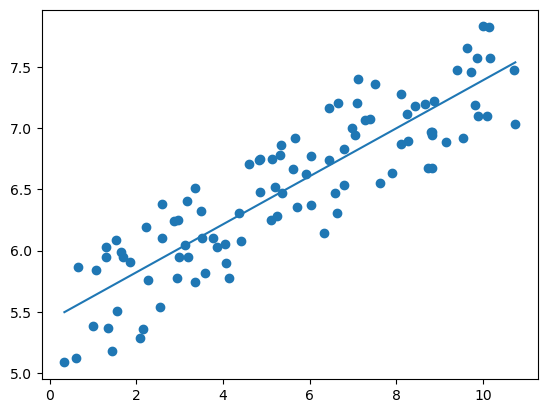

In [165]:
scatter_with_trendline(
    np.linspace(0, 10, 100) + np.random.rand(100),
    np.linspace(5, 7, 100) + np.random.rand(100),
    label="thing"
)

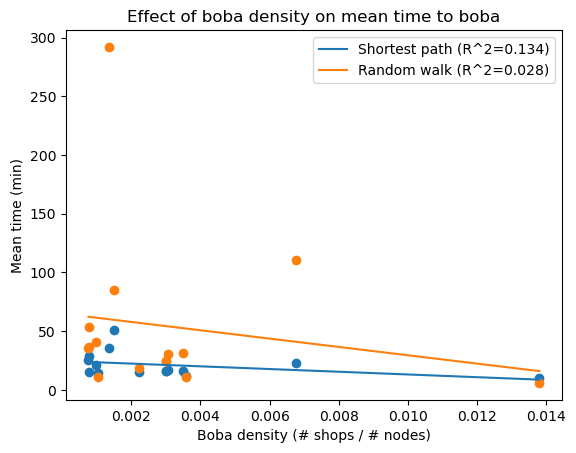

In [173]:
boba_density = {slug: len(data[slug][2]) / len(data[slug][0].nodes()) for slug in ideal_slugs}

scatter_with_trendline([boba_density[slug] for slug in ideal_slugs], ideal_times, label="Shortest path")
scatter_with_trendline([boba_density[slug] for slug in random_slugs], random_times, label="Random walk")

plt.xlabel("Boba density (# shops / # nodes)")
plt.ylabel("Mean time (min)")
plt.title("Effect of boba density on mean time to boba")

""" plt.xscale("log")
plt.yscale("log") """

plt.legend()